In [2]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

import squidpy as sq
from bin import load_bgi as ld
import seaborn as sns

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
sc.settings.verbosity = 3

import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline
plt.rcParams['figure.figsize']=(7,4)

In [3]:
def calculate_composition(adata, groupby_key, category_key):
    data = pd.DataFrame(adata.obs)
    composition = data.groupby(groupby_key)[category_key].value_counts(normalize=True).unstack(fill_value=0)
    return composition


def plot_composition(composition_df, title, x, y, palette='viridis'):
    if isinstance(palette, str):
        cmap = plt.get_cmap(palette)
        colors = cmap(np.linspace(0, 1, composition_df.shape[1]))
    elif isinstance(palette, list):
        colors = palette
    else:
        raise ValueError("Palette should be a string (colormap name) or a list of colors")
    
    ax = composition_df.plot(kind='bar', stacked=True, figsize=(6, 4), color=colors, fontsize=8)
    
    plt.title(title)
    plt.ylabel('Proportion')
    plt.xlabel(x)

    plt.legend(title=y, bbox_to_anchor=(1.05, 1), loc='upper left')

    sns.despine()
    ax.yaxis.grid(False)
    ax.xaxis.grid(False)

    plt.tight_layout()
    plt.show()

In [4]:
import json
with open("./marker_stage1.json", "r") as json_file:
    marker_stage1 = json.load(json_file)
with open("./marker_stage2.json", "r") as json_file:
    marker_stage2 = json.load(json_file)

In [5]:
def to_mouse_gene(gene_name_list):
    return [gene_name[0] + gene_name[1:].lower() for gene_name in gene_name_list]

In [6]:
from collections import defaultdict
marker_dict = defaultdict(list)
for key in marker_stage1.keys():
    marker_dict[key].extend(marker_stage1[key])
for key in marker_stage2.keys():
    marker_dict[key].extend(marker_stage2[key])
for key, value in marker_dict.items():
    marker_dict[key] = list(set(marker_dict[key]))
dict_ref = {
    "NK": ["NK"], 
    "T": ["T"], 
    #"B": ["B", "Plasma"], 
    #"Neutrophils": ["Neutrophils"],
    "Macrophages": ["Macrophages","Monocyte"],
    "DC": ["DC"],
    "Endothelial":["Endothelial"],
    "Fibroblast": ["Fibroblasts","Myofibroblast"],
    'MuscleCell':["SmoothMuscle"],
    "Epithelial": [ "Malignant", "Epithelial"],
    # "Hepatocytes": ["Hepatocytes/cholangiocytes"]
}
epithelial_marker_2 = {
    # "Arterial": ["SOX17", "EFNB2", "GJA5", "DKK2", "FBLN5", "HEY1", "IGFBP3"],  "Postcapillary vains": ["ACKR1", "SELP", "VCAM1"], "Capillaries": ["CA4", "CD36", "IL7R", "AFF3", "BTNL9"],
    "Epithelial": ['PIGR', 'PHGR1', 'ITM2C', 'MT1E', 'CA2', 'MT1G', 'MT2A', 'VSIG2', 'TSPAN1', 'FABP1', 'MT1M', 'PLAC8', 'FCGBP', 'PKIB', 'GUCA2A', 'MT1F', 'LYPD8', 'PADI2', 'MT1H', 'MUC4', 'ZG16', 'FABP2', 'PLA2G2A', 'B3GNT7', 'GUCA2B', 'CEACAM7', 'BCAS1', 'CA4', 'SLC4A4', 'UGT2B17', 'XIST', 'CHP2', 'CA1', 'C2orf88', 'CPM', 'DHRS9', 'HRCT1', 'HSD17B2', 'CD177', 'ENTPD8', 'B3GALT5', 'CLCA4', 'ADH1C', 'SLC26A3', 'NXPE4', 'GPT', 'SCIN', 'ITLN1', 'CA7', 'SLC16A9', 'MS4A12', 'SPIB', 'SCNN1B', 'SLC17A4', 'NEURL1', 'CTSE', 'BEST4', 'OTOP2', 'REP15', 'NR3C2', 'ADTRP', 'AKR1B10', 'SI', 'SPINK5', 'AQP8', 'BTNL8', 'SLC51B', 'MMP28', 'CLCA1', 'TPSG1', 'EDN3', 'CLDN8', 'LGALS9B', 'TMIGD1', 'GPAT3', 'CPNE8', 'LGALS9C', 'LAMA1', 'RNF152', 'C11orf86', 'LDHD', 'TMEM236', 'BEST2', 'SULT1A2', 'HRASLS2', 'ABCG2', 'SCGB2A1', 'SLCO2A1', 'TMEM82', 'BMP3', 'KCNMA1', 'CEACAM3', 'TBX10', 'FAM177B', 'MYOM1', 'FSIP2', 'MEIS1', 'UGT2B15', 'SLC28A2', 'B3GNT6'],
    # "Epithelial":['EPCAM'],
    "Malignant": ['ASCL2', 'TGFBI', 'NKD1', 'DPEP1', 'BMP4', 'GNG4', 'DACH1', 'CLDN1', 'KRT23', 'ETV4', 'SP5', 'NOTUM', 'TESC', 'TDGF1', 'FOXQ1', 'APCDD1', 'C2', 'SNTB1', 'GPR155', 'SLC7A5', 'SLC29A1', 'LGR5', 'BAMBI', 'MTRNR2L12', 'MATR3', 'COL9A3', 'DEFA5', 'CAB39L', 'MTRNR2L8', 'ACSL6', 'PLCB1', 'FKBP10', 'CEMIP', 'FZD10', 'DEFA6', 'PEG10', 'PTP4A3', 'KIZ', 'KRT5', 'PLTP', 'ETV5', 'CST1', 'BMP7', 'WFS1', 'GAL', 'STXBP1', 'CELF3', 'GLIPR1', 'CEL', 'NR2F1', 'SEMA3A', 'FILIP1L', 'CYP2W1', 'LEF1', 'BOP1', 'SMOC2', 'MUCL1', 'FGF20', 'PACSIN3', 'EDAR', 'IGF2BP3', 'RBMS1', 'GAD1', 'TNFRSF19', 'PROCR', 'TGFBR3', 'LGR6', 'ABHD12B', 'CXCL14', 'VGF', 'MEX3A', 'OSR2', 'NRCAM', 'INHBB', 'FAM89A', 'NKD2', 'STMN3', 'DEPDC7', 'STC2', 'LAMA5', 'KCNMB4', 'DKK4', 'CKMT2', 'TMEM154', 'CAPN6', 'FADS1', 'PLAG1', 'DLX3', 'FBLN1', 'MSX1', 'FOXD1', 'TMEM132C', 'BAG2', 'OLFML3', 'TIMP3', 'UPK1A', 'SMIM3', 'CELF4', 'FGF19', 'PALD1'],
}
marker_dict_0 = {}
for new_key, old_keys in dict_ref.items():
    merged_list = []
    for old_key in old_keys:
        merged_list.extend(marker_dict.get(old_key, []))
    marker_dict_0[new_key] = merged_list
for i, j in marker_dict_0.items():
    print(f"Cell type of {i} has {len(j)} markers.")
marker_dict_CC = {key:val for key, val in marker_dict_0.items() if key!="Hepatocytes"}
marker_dict_LM = marker_dict_0

Cell type of NK has 10 markers.
Cell type of T has 65 markers.
Cell type of Macrophages has 31 markers.
Cell type of DC has 25 markers.
Cell type of Endothelial has 8 markers.
Cell type of Fibroblast has 10 markers.
Cell type of MuscleCell has 10 markers.
Cell type of Epithelial has 45 markers.


In [1]:
sig_dict={
    'SPP1+IL1+ macro':['IL1B', 'CXCL8', 'SOD2', 'BCL2A1', 'CXCL2', 'CCL20', 'CXCL3', 'G0S2', 'C15orf48', 'PLAUR', 'EREG', 'IL1RN', 'TIMP1', 'BTG1', 'CD44', 'CCL3', 'PTGS2', 'NAMPT', 'SLC25A37', 'AQP9', 'SLC2A3', 'IL1A', 'TREM1', 'TNFAIP6', 'SERPINB9', 'INHBA', 'EHD1', 'S100A8', 'VCAN', 'NFKB1', 'GK', 'NLRP3', 'TNIP3', 'CCL4L2', 'IL6', 'S100A12', 'TNIP1', 'CD300E', 'CXCL1', 'FLT1', 'THAP2', 'AREG', 'SERPINB2', 'TRAF1', 'CXCL5', 'SLC7A5', 'IRAK2', 'ANGPTL4', 'F3', 'CDC42EP3', 'IL23A', 'DNAAF1', 'MAP4K4', 'ITGB8', 'PTX3', 'TRGC1', 'IL1R1', 'TNFSF14', 'SLCO4A1', 'CRADD', 'AK4', 'SLC7A11', 'HS3ST3B1', 'SLAMF1', 'MSC', 'MFSD2A', 'HILPDA', 'TNFSF15', 'TM4SF1', 'ADAM19', 'CSF3', 'LAMB3', 'NT5E', 'ZP3', 'ZNF697', 'GJB2', 'ACKR3', 'ECE1', 'HEY1', 'TMEM158', 'PRDM8', 'TRGC2', 'FAM124A', 'C6orf223', 'SYN1', 'EDN1', 'GGT5', 'TRGV5', 'NEU4', 'DGAT2', 'MET', 'CEMIP', 'S1PR3', 'ELOVL7', 'MN1', 'HAS1', 'ADGRG3', 'PTGES', 'C16orf74', 'MGAM'],
    'SPP1+TREM2+ macro':['S100A6', 'LGALS1', 'S100A10', 'FABP5', 'CSTB', 'SPP1', 'FBP1', 'LSP1', 'CD9', 'CD52', 'GCHFR', 'S100A9', 'GLIPR2', 'APOC1', 'S100A8', 'CYP27A1', 'FN1', 'MGST1', 'SDC2', 'LPL', 'MATK', 'RETN', 'HSD3B7', 'CCL7', 'CHI3L1', 'TM4SF19', 'CST6', 'PPARG', 'HAMP', 'SEMA3C', 'DCSTAMP', 'SPOCD1', 'PCOLCE2', 'CHIT1', 'MMP7', 'AGRP', 'PHLDA3', 'JAKMIP2', 'ANKRD29', 'PRSS21', 'TPST1', 'HPGD', 'CES1', 'TIMP3', 'CYP19A1', 'HSD11B1', 'COL22A1', 'PAQR5', 'ADORA2B', 'ACOX2', 'SCG5', 'ALDH1A2', 'FABP4', 'CEBPE', 'SLC28A3', 'CRABP2', 'ASPHD1', 'DNASE2B', 'GPC4', 'FLRT2', 'CNIH3', 'GLDN', 'KCNJ15', 'GOLGA7B', 'MYOZ1', 'UCHL1', 'FBXO15', 'LEP', 'NLRP12', 'SLC22A16', 'WDR86', 'GAL', 'HES2', 'GPR27', 'TIMP4', 'EPHB1', 'PNCK', 'ELANE', 'GPD1', 'PHOSPHO1', 'SLCO4C1', 'PPM1J', 'KLHDC9'],
    'SPP1+MMP+ macro':['C15orf48', 'MMP9', 'MMP12', 'SPP1', 'CXCL8', 'IL7R', 'BAG3', 'SLAMF9', 'SLC7A11', 'CXCL5', 'ENO2', 'SLC2A1', 'TNFRSF9', 'MMP1', 'MMP10', 'COL6A2', 'CYP27B1', 'CA12', 'SIGLEC15', 'TMEM45A', 'ITGB3', 'MUCL1', 'NEURL3', 'CP', 'C1QTNF1', 'AK8', 'CLLU1OS', 'CXCL6', 'FGF11', 'LAD1', 'TMEM132A', 'RNF207', 'GPR68', 'MYO1B', 'FJX1', 'CACNA1G', 'A4GALT', 'HTRA3', 'PPP1R1A', 'CD1A', 'COL27A1', 'ACTRT3', 'CRYAB', 'LAYN', 'NELL2', 'ADAMTS14', 'TGFBR3L', 'RTN4RL2', 'CGA', 'MT3', 'CCDC74A', 'RNF32', 'KISS1R'],
    'FOLR2+ macro':['C1QA', 'C1QB', 'MS4A6A', 'C1QC', 'SLC40A1', 'FOLR2', 'PDK4', 'MAF', 'MS4A7', 'GPR34', 'HLA-DQA1', 'SDC3', 'FGL2', 'CXCL12', 'CD163', 'CD302', 'LILRB5', 'SLCO2B1', 'CD5L', 'P2RY13', 'VCAM1', 'MPEG1', 'AXL', 'FRMD4B', 'LYVE1', 'WWP1', 'CETP', 'EPB41L2', 'LTC4S', 'METTL7A', 'DST', 'FRMD4A', 'SLC9A9', 'GATM', 'F13A1', 'IGF1', 'RGL1', 'TCF4', 'TMEM37', 'SESN1', 'NFIA', 'PDGFC', 'GPR155', 'CFP', 'ME1', 'RGS18', 'SCN1B', 'ATP6V0C', 'NDST3', 'CR1', 'MAN2B1', 'ITLN1', 'CLIC2', 'CD163L1', 'ADGRG6', 'FILIP1L', 'CD209', 'SESN3', 'RBP7', 'EBI3', 'ADORA3', 'GFRA2', 'MYO9A', 'KCNJ2', 'IGFBP4', 'SLC46A3', 'CYSLTR1', 'ITSN1', 'STON2', 'GCNT1', 'ALB', 'QPRT', 'EPS8', 'CPED1', 'IGSF21', 'NFATC2', 'RND3', 'TXNDC16', 'ITGAD', 'GIMAP5', 'EXT1', 'ITGA9', 'GIMAP8', 'CDH5', 'RAB3IL1', 'TIMD4', 'CNRIP1', 'HDAC9', 'SLC46A1', 'SIGLEC11', 'KCNAB1', 'HPGDS', 'SHE', 'PIK3R3', 'TBC1D4', 'SRGAP3', 'PROS1', 'FEZ1', 'TMEM26', 'CTSF'],
    'CXCL9+ macro': ['ISG15', 'IFITM3', 'CXCL10', 'GBP1', 'LY6E', 'ISG20', 'IFI6', 'TNFSF13B', 'LAP3', 'WARS', 'EPSTI1', 'TNFSF10', 'STAT1', 'MX1', 'IFIT3', 'VAMP5', 'TAP1', 'IFI35', 'GBP4', 'GBP5', 'IFI44L', 'PPA1', 'IFIT2', 'RSAD2', 'IRF7', 'MX2', 'IFIT1', 'APOBEC3A', 'CXCL11', 'ANKRD22', 'SAMD9L', 'OAS2', 'GCH1', 'IDO1', 'IFIH1', 'CXCL9', 'OAS3', 'HERC5', 'NT5C3A', 'SP110', 'CMPK2', 'OASL', 'FCN1', 'IFITM1', 'SLAMF7', 'HAPLN3', 'CCL8', 'LILRA5', 'USP18', 'DDX58', 'APOL3', 'ETV7', 'DEFB1', 'CD274', 'FPR2', 'IL27', 'LMNB1', 'SELL', 'GMPR', 'HELZ2', 'HESX1', 'NEXN', 'HSH2D', 'HERC6', 'LAMP3', 'CLEC4D', 'ADAM19', 'MEFV', 'ZBP1', 'EXOC3L1', 'CCR2', 'UBD', 'BCL2L14', 'CASP5', 'STAP1', 'BATF2', 'APOBEC3B', 'TGM1', 'FFAR2', 'GBP7', 'ATP10A', 'CCL19', 'STEAP4', 'NTNG2', 'IDO2', 'RUFY4', 'KCTD14', 'NPFFR1']
}

In [ ]:
sig_dict= {'SPP1+IL1+ macro': ['IL1B', 'CXCL8', 'SOD2', 'BCL2A1', 'CXCL2', 'CCL20', 'CXCL3', 'G0S2', 'C15orf48', 'PLAUR', 'EREG', 'IL1RN', 'TIMP1', 'BTG1', 'CD44', 'CCL3', 'PTGS2', 'NAMPT', 'SLC25A37', 'AQP9', 'SLC2A3', 'IL1A', 'TREM1', 'TNFAIP6', 'SERPINB9', 'INHBA', 'EHD1', 'S100A8', 'VCAN', 'NFKB1', 'GK', 'NLRP3', 'TNIP3', 'CCL4L2', 'IL6', 'S100A12', 'TNIP1', 'CD300E', 'CXCL1', 'FLT1', 'THAP2', 'AREG', 'SERPINB2', 'TRAF1', 'CXCL5', 'SLC7A5', 'IRAK2', 'ANGPTL4', 'F3', 'CDC42EP3', 'IL23A', 'DNAAF1', 'MAP4K4', 'ITGB8', 'PTX3', 'TRGC1', 'IL1R1', 'TNFSF14', 'SLCO4A1', 'CRADD', 'AK4', 'SLC7A11', 'HS3ST3B1', 'SLAMF1', 'MSC', 'MFSD2A', 'HILPDA', 'TNFSF15', 'TM4SF1', 'ADAM19', 'CSF3', 'LAMB3', 'NT5E', 'ZP3', 'ZNF697', 'GJB2', 'ACKR3', 'ECE1', 'HEY1', 'TMEM158', 'PRDM8', 'TRGC2', 'FAM124A', 'C6orf223', 'SYN1', 'EDN1', 'GGT5', 'TRGV5', 'NEU4', 'DGAT2', 'MET', 'CEMIP', 'S1PR3', 'ELOVL7', 'MN1', 'HAS1', 'ADGRG3', 'PTGES', 'C16orf74', 'MGAM'],
 'SPP1+TREM2+ macro': ['S100A6', 'LGALS1', 'S100A10', 'FABP5', 'CSTB', 'SPP1', 'FBP1', 'LSP1', 'CD9', 'CD52', 'GCHFR', 'S100A9', 'GLIPR2', 'APOC1', 'S100A8', 'CYP27A1', 'FN1', 'MGST1', 'SDC2', 'LPL', 'MATK', 'RETN', 'HSD3B7', 'CCL7', 'CHI3L1', 'TM4SF19', 'CST6', 'PPARG', 'HAMP', 'SEMA3C', 'DCSTAMP', 'SPOCD1', 'PCOLCE2', 'CHIT1', 'MMP7', 'AGRP', 'PHLDA3', 'JAKMIP2', 'ANKRD29', 'PRSS21', 'TPST1', 'HPGD', 'CES1', 'TIMP3', 'CYP19A1', 'HSD11B1', 'COL22A1', 'PAQR5', 'ADORA2B', 'ACOX2', 'SCG5', 'ALDH1A2', 'FABP4', 'CEBPE', 'SLC28A3', 'CRABP2', 'ASPHD1', 'DNASE2B', 'GPC4', 'FLRT2', 'CNIH3', 'GLDN', 'KCNJ15', 'GOLGA7B', 'MYOZ1', 'UCHL1', 'FBXO15', 'LEP', 'NLRP12', 'SLC22A16', 'WDR86', 'GAL', 'HES2', 'GPR27', 'TIMP4', 'EPHB1', 'PNCK', 'ELANE', 'GPD1', 'PHOSPHO1', 'SLCO4C1', 'PPM1J', 'KLHDC9'],
 'SPP1+MMP+ macro': ['C15orf48', 'MMP9', 'MMP12', 'SPP1', 'CXCL8', 'IL7R', 'BAG3', 'SLAMF9', 'SLC7A11', 'CXCL5', 'ENO2', 'SLC2A1', 'TNFRSF9', 'MMP1', 'MMP10', 'COL6A2', 'CYP27B1', 'CA12', 'SIGLEC15', 'TMEM45A', 'ITGB3', 'MUCL1', 'NEURL3', 'CP', 'C1QTNF1', 'AK8', 'CLLU1OS', 'CXCL6', 'FGF11', 'LAD1', 'TMEM132A', 'RNF207', 'GPR68', 'MYO1B', 'FJX1', 'CACNA1G', 'A4GALT', 'HTRA3', 'PPP1R1A', 'CD1A', 'COL27A1', 'ACTRT3', 'CRYAB', 'LAYN', 'NELL2', 'ADAMTS14', 'TGFBR3L', 'RTN4RL2', 'CGA', 'MT3', 'CCDC74A', 'RNF32', 'KISS1R'],
 'FOLR2+ macro': ['C1QA', 'C1QB', 'MS4A6A', 'C1QC', 'SLC40A1', 'FOLR2', 'PDK4', 'MAF', 'MS4A7', 'GPR34', 'HLA-DQA1', 'SDC3', 'FGL2', 'CXCL12', 'CD163', 'CD302', 'LILRB5', 'SLCO2B1', 'CD5L', 'P2RY13', 'VCAM1', 'MPEG1', 'AXL', 'FRMD4B', 'LYVE1', 'WWP1', 'CETP', 'EPB41L2', 'LTC4S', 'METTL7A', 'DST', 'FRMD4A', 'SLC9A9', 'GATM', 'F13A1', 'IGF1', 'RGL1', 'TCF4', 'TMEM37', 'SESN1', 'NFIA', 'PDGFC', 'GPR155', 'CFP', 'ME1', 'RGS18', 'SCN1B', 'ATP6V0C', 'NDST3', 'CR1', 'MAN2B1', 'ITLN1', 'CLIC2', 'CD163L1', 'ADGRG6', 'FILIP1L', 'CD209', 'SESN3', 'RBP7', 'EBI3', 'ADORA3', 'GFRA2', 'MYO9A', 'KCNJ2', 'IGFBP4', 'SLC46A3', 'CYSLTR1', 'ITSN1', 'STON2', 'GCNT1', 'ALB', 'QPRT', 'EPS8', 'CPED1', 'IGSF21', 'NFATC2', 'RND3', 'TXNDC16', 'ITGAD', 'GIMAP5', 'EXT1', 'ITGA9', 'GIMAP8', 'CDH5', 'RAB3IL1', 'TIMD4', 'CNRIP1', 'HDAC9', 'SLC46A1', 'SIGLEC11', 'KCNAB1', 'HPGDS', 'SHE', 'PIK3R3', 'TBC1D4', 'SRGAP3', 'PROS1', 'FEZ1', 'TMEM26', 'CTSF'],
 'CXCL9+ macro': ['ISG15', 'IFITM3', 'CXCL10', 'GBP1', 'LY6E', 'ISG20', 'IFI6', 'TNFSF13B', 'LAP3', 'WARS', 'EPSTI1', 'TNFSF10', 'STAT1', 'MX1', 'IFIT3', 'VAMP5', 'TAP1', 'IFI35', 'GBP4', 'GBP5', 'IFI44L', 'PPA1', 'IFIT2', 'RSAD2', 'IRF7', 'MX2', 'IFIT1', 'APOBEC3A', 'CXCL11', 'ANKRD22', 'SAMD9L', 'OAS2', 'GCH1', 'IDO1', 'IFIH1', 'CXCL9', 'OAS3', 'HERC5', 'NT5C3A', 'SP110', 'CMPK2', 'OASL', 'FCN1', 'IFITM1', 'SLAMF7', 'HAPLN3', 'CCL8', 'LILRA5', 'USP18', 'DDX58', 'APOL3', 'ETV7', 'DEFB1', 'CD274', 'FPR2', 'IL27', 'LMNB1', 'SELL', 'GMPR', 'HELZ2', 'HESX1', 'NEXN', 'HSH2D', 'HERC6', 'LAMP3', 'CLEC4D', 'ADAM19', 'MEFV', 'ZBP1', 'EXOC3L1', 'CCR2', 'UBD', 'BCL2L14', 'CASP5', 'STAP1', 'BATF2', 'APOBEC3B', 'TGM1', 'FFAR2', 'GBP7', 'ATP10A', 'CCL19', 'STEAP4', 'NTNG2', 'IDO2', 'RUFY4', 'KCTD14', 'NPFFR1']}

In [7]:
for marker in marker_dict_0:
    marker_dict_0[marker] = to_mouse_gene(marker_dict_0[marker])
for marker in marker_dict_LM:
    marker_dict_LM[marker] = to_mouse_gene(marker_dict_LM[marker])
for marker in marker_dict_CC:
    marker_dict_CC[marker] = to_mouse_gene(marker_dict_CC[marker])
for marker in marker_stage1:
    marker_stage1[marker] = to_mouse_gene(marker_stage1[marker])
for marker in marker_stage2:
    marker_stage2[marker] = to_mouse_gene(marker_stage2[marker])
for marker in epithelial_marker_2:
    epithelial_marker_2[marker] = to_mouse_gene(epithelial_marker_2[marker])

In [8]:
from skimage.morphology import dilation, square
from tqdm import tqdm

def compute_relative_abundance(adata, dict_use):
    relative_abundances = {}
    for cell_type, markers in tqdm(dict_use.items()):
        avg_expressions = []
        for marker in markers:
            if marker not in adata.var_names:
                continue
            expressed_values = adata[:, marker].X[adata[:, marker].X > 0]
            # Check if there are any expressed values
            if isinstance(expressed_values, np.ndarray):
                num_nonzero = len(expressed_values)
            else:  # Assuming it's a sparse matrix
                num_nonzero = expressed_values.getnnz()
            if num_nonzero > 0:
                avg_expressions.append(np.mean(expressed_values))
            else:
                avg_expressions.append(0)
        relative_abundance = np.log10(sum(avg_expressions) + 1e-10)
        relative_abundances[cell_type] = 1 / relative_abundance
    return relative_abundances

def annotate_cells_stage(marker_dict_use, adata, cells_to_annotate=None):
    WCT = compute_relative_abundance(adata, marker_dict_use)
    annotations = {}
    unannotated_cells = []

    if cells_to_annotate is None:
        cells_to_annotate = adata.obs_names
        data_submatrix = adata.X
    else:
        data_submatrix = adata[cells_to_annotate, :].X

    all_scores = np.zeros((len(cells_to_annotate), len(marker_dict_use)))
    print(all_scores.shape)
    for idx, (cell_type, markers) in enumerate(marker_dict_use.items()):
        valid_markers_indices = [
            adata.var_names.get_loc(marker)
            for marker in markers
            if marker in adata.var_names
        ]
        marker_matrix = data_submatrix[:, valid_markers_indices]
        presence_matrix = (marker_matrix > 0).astype(int)
        scores = presence_matrix.sum(axis=1) * WCT[cell_type]

        all_scores[:, idx] = scores.ravel()
    max_scores = np.max(all_scores, axis=1)
    max_score_indices = np.argmax(all_scores, axis=1)
    cell_types = list(marker_dict_use.keys())
    annotations = np.array(
        [
            cell_types[idx] if score > 0 else "Others"
            for idx, score in zip(max_score_indices, max_scores)
        ]
    )
    unannotated = [cells_to_annotate[i] for i in np.where(annotations == "Others")[0]]
    return dict(zip(cells_to_annotate, annotations)), unannotated

def visualize_results(adata, ax, key="annotations"):
    # Plotting
    cell_types, counts = np.unique(adata.obs[key], return_counts=True)
    ax.bar(cell_types, counts)
    # Annotate each bar with its value
    for i, value in enumerate(counts):
        ax.text(i, value, str(value), ha="center", va="bottom", fontsize=8)
    ax.set_xticks(cell_types)
    ax.set_xticklabels(cell_types, rotation=90)

In [150]:
fdata_2 = ld.load_bin(gem_file="gRNA/B922/cut.combined.D03658A1.merged.sgRNA.gem",
                    bin_size=20,
                    library_id="gRNA")

In [151]:
guide_genes = fdata_2.var_names.str.startswith('sg')
gdata_2 = fdata_2[:, guide_genes].copy()
adata_2 = fdata_2[:, ~np.isin(fdata_2.var_names, guide_genes)].copy()

In [152]:
gdata_2.write_h5ad("./RNA/B922-1.guide.bin_20.h5")
adata_2.write_h5ad("./RNA/B922-1.expr.bin_20.h5")

In [153]:
sc.pp.filter_cells(adata_2, min_genes=1)
adata_2.var["mt1"] = adata_2.var_names.str.startswith("Mt-")
adata_2.var["mt2"] = adata_2.var_names.str.startswith("mt")
adata_2.var["rb"] = adata_2.var_names.str.startswith("Rp")

#adata_2 = adata_2[:, ~adata_2.var["mt1"]].copy()
#adata_2 = adata_2[:, ~adata_2.var["mt2"]].copy()
#adata_2 = adata_2[:, ~adata_2.var["rb"]].copy()
adata_2.layers["counts"] = adata_2.X

In [154]:
sc.pp.normalize_total(adata_2, target_sum=1e4)
sc.pp.log1p(adata_2)

normalizing counts per cell
    finished (0:00:00)


In [9]:
data_list = ["./RNA/B924-1.expr.bin_20.h5", "./RNA/B926-1.expr.bin_20.h5", "./RNA/B922-1.expr.bin_20.h5",
             "./RNA/B924-2.expr.bin_20.h5", "./RNA/B926-2.expr.bin_20.h5", "./RNA/B922-2.expr.bin_20.h5"]
marker = ["1-1", "2-1", "3-1", "1-2", "2-2", "3-2"]
anndata_list = []
for idx, data in enumerate(data_list):
    anndata_ = sc.read_h5ad(data)
    anndata_.obs["marker"] = marker[idx]
    anndata_list.append(anndata_)

In [25]:
combined_data = ad.concat(anndata_list)
combined_data.obs_names_make_unique()

fdata = combined_data.copy()

In [11]:
fdata.var["mt"] = fdata.var_names.str.startswith("Mt")
fdata.var["mt-"] = fdata.var_names.str.startswith("mt-")
fdata.var["gm"] = fdata.var_names.str.startswith("Gm")
fdata.var["Rb"] = fdata.var_names.str.startswith("Rp")
fdata.var["rik"] = [True if "Rik" in str else False for str in fdata.var_names]
fdata = fdata[:, ~fdata.var["mt"]].copy()
fdata = fdata[:, ~fdata.var["mt-"]]
fdata = fdata[:, ~fdata.var["Rb"]]
fdata = fdata[:, ~fdata.var["gm"]]
fdata = fdata[:, ~fdata.var["rik"]]

sc.pp.filter_cells(fdata, min_genes=3)
sc.pp.filter_genes(fdata, min_cells=3)

filtered out 28538 cells that have less than 3 genes expressed


In [12]:
with open("He2020Nature_mouseHK.txt", 'r') as f:
    for line in f:
        hk_genes = line.split('\t')
        break
fdata = fdata[:, [gene for gene in fdata.var_names if gene not in hk_genes]]

In [13]:
fdata.write_h5ad('./RNA/Multitime.filtered.tissue.bin20.h5')

In [ ]:
fdata = sc.read_h5ad('./RNA/Multitime.filtered.tissue.bin20.h5')

In [15]:
fdata.layers["counts"] = fdata.X.copy()
sc.pp.normalize_total(fdata, target_sum=1e4)
sc.pp.log1p(fdata)

normalizing counts per cell
    finished (0:00:02)


In [26]:
annotations, unannotated_cells = annotate_cells_stage(marker_dict_CC, fdata)
print("There are {} cells remaining unannotated.".format(len(unannotated_cells)))

100%|██████████| 8/8 [04:16<00:00, 32.11s/it]


(2910460, 8)
There are 523063 cells remaining unannotated.


In [27]:
fdata.obs["annotations"] = pd.Series(annotations).astype("category")

In [28]:
adata_epi = fdata[fdata.obs["annotations"] == "Epithelial", :].copy()
annotations, unannotated_cells_stage_1 = annotate_cells_stage(epithelial_marker_2, adata_epi)
annotations_stage_2, unannotated = annotate_cells_stage( {key:val for key, val in marker_stage1.items() if key in ["Malignant", "Epithelial"]}, adata_epi,
                                                        cells_to_annotate=unannotated_cells_stage_1) 

100%|██████████| 2/2 [01:37<00:00, 48.86s/it]


(959920, 2)


100%|██████████| 2/2 [00:23<00:00, 11.60s/it]


(306540, 2)


In [29]:
for idx, ann in annotations_stage_2.items():
    annotations[idx] = ann
adata_epi.obs["anno_1"] = pd.Series(annotations).astype("category")
adata_epi.obs['anno_1'] = np.array(adata_epi.obs['anno_1'])
fdata.obs["annotations"] = np.array(fdata.obs["annotations"])
fdata.obs.loc[adata_epi.obs.index, "annotations"] = adata_epi.obs['anno_1']

fdata.obs["annotations"] = pd.Series(fdata.obs["annotations"]).astype("category")
fdata.obs['annotations'] = fdata.obs['annotations'].cat.reorder_categories(['NK', 'T', 'DC', 'Macrophages', 'Epithelial', 'Malignant', 'Endothelial', 'Fibroblast', 'MuscleCell', 'Others'], ordered = True)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:34)


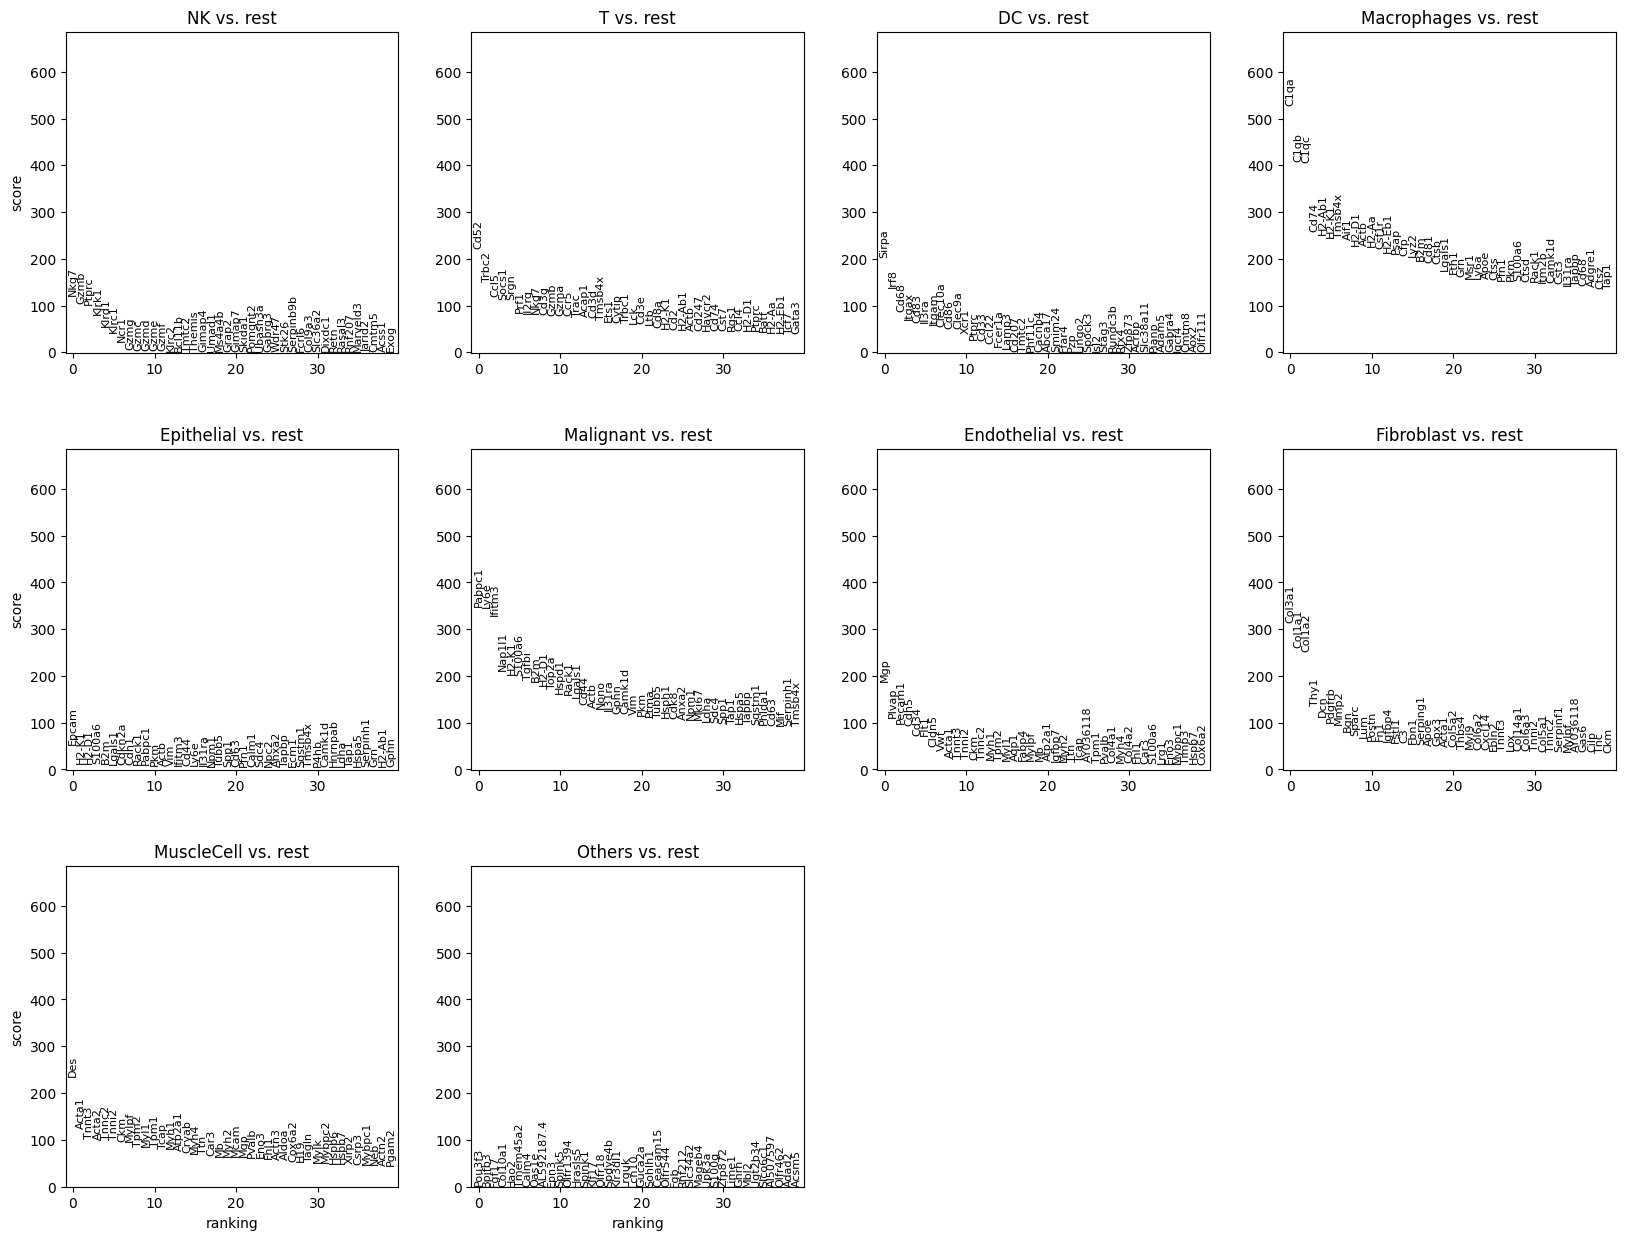

In [18]:
plt.rcParams['figure.figsize']=(5,5)
sc.tl.rank_genes_groups(fdata, groupby='annotations') 
sc.pl.rank_genes_groups(fdata, n_genes=40)

In [160]:
adata_2.write_h5ad("./RNA/B922-1.expr.bin_20.annotation.h5")

In [30]:
T_marker = {
    "memory T": ['Cd8a','Cd8b', "Il7r", "Cd27", 'Ccr4','Eomes','Gpr183'],
    "effector T": ['Cd8a','Cd8b', 'Cd69','Ifng','Fgfbp2','Gzmh',"Gzmk", "Gzma", "Gzmb", "Prf1", "Gnly", "Nkg7"],
    "exhausted T": ['Cd8a','Cd8b', "Lag3", "Pdcd1", "Tigit", "Ctla4", 'Tox', 'Sirpg','Tnfrsf9','Tnfrsf18',  'Cxcr6', 'Cxcl13'],
    "stem-like T": ["Tcf7", "Foxo1"]
}

Ptprc	Ptprc	Vwf	Col1a1	Mki67	Cdh1	Acta2
Cd3d	Cd14	Pecam1	Col1a2	Epcam	Epcam	My19
Cd3g	Itgam	Cldn5	Col3a1	Top2a	Cdkn2a	Myh11
Cd3e	Itgax	Cdh5	Mmp2	Ascl2	Krt5	Mylk
Cd8a	Trem2	Mgp	Myl9	Cbx3	Krt17	Tagln
Cd4	Fcgr3a		Dcn	Hsp90ab1	Muc5b	Mcam
Trbc1	Cd1c		Fap	Dpep1		Pck1
Trbc2	Cd209			Dkc1		Ass1
Trac	Ccl22			Bmp4		Hamp
Gnly	Cd86			Gng4		Pck1
Klrg1	Clec9a			Cpne1		Ttrdefb1
Gzmb	Clec10a			Zdhhc9		Actg2
Prf1	Xcr1			Dars		Mgp
Gzmk	Lamp3			Scd		Des
Ccr7				Myc		Tmp1
Il7r				Phlda1		
Sell				Dach1		
Tcf7				Cldn1		
Lag3				Krt23		
Layn				Zfas1		
Havcr2				Pabpc1		
Ctla4				Gtf3a		
Ggt1				Nap1l1		
Tigit				Tgfbi		
Cd160				Ifitm3		
Tox				Hspd1		
Prdm1				Nono		
Socs1				Hsph1		
Eomes				Hkd1		
Tbx21				Ly6e		
Batf				C6orf48		
Foxo1				Ssb		
Cd4				Rsl1d1		
Foxp3						
Gata3						
Tbx21						
Cxcr3						
Cd8b						


In [31]:
adata_t = fdata[fdata.obs["annotations"] == "T", :].copy()
annotations, unannotated_cells_stage_1 = annotate_cells_stage(T_marker, adata_t)

 50%|█████     | 2/4 [00:02<00:02,  1.07s/it]

100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


(172008, 4)


In [32]:
annotations = {k: ("Unknown T" if v == "Others" else v) for k, v in annotations.items()}

In [33]:
adata_t.obs["anno_1"] = pd.Series(annotations).astype("category")
adata_t.obs['anno_1'] = np.array(adata_t.obs['anno_1'])

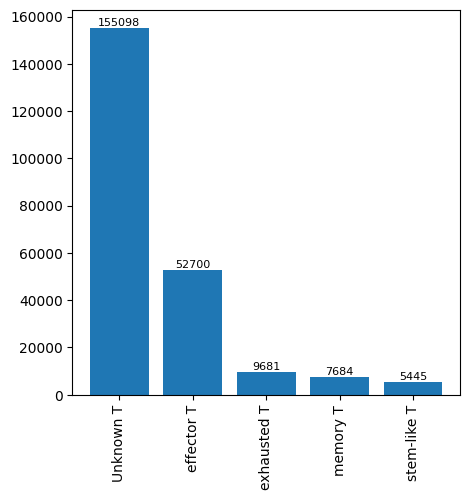

In [17]:
fig, ax = plt.subplots(figsize=(5, 5))
visualize_results(adata_t, ax, key="anno_1")

In [18]:
fdata

AnnData object with n_obs × n_vars = 2910460 × 13177
    obs: 'marker', 'annotations'
    var: 'mt', 'mt-', 'gm', 'Rb', 'rik'
    uns: 'rank_genes_groups'
    obsm: 'spatial'

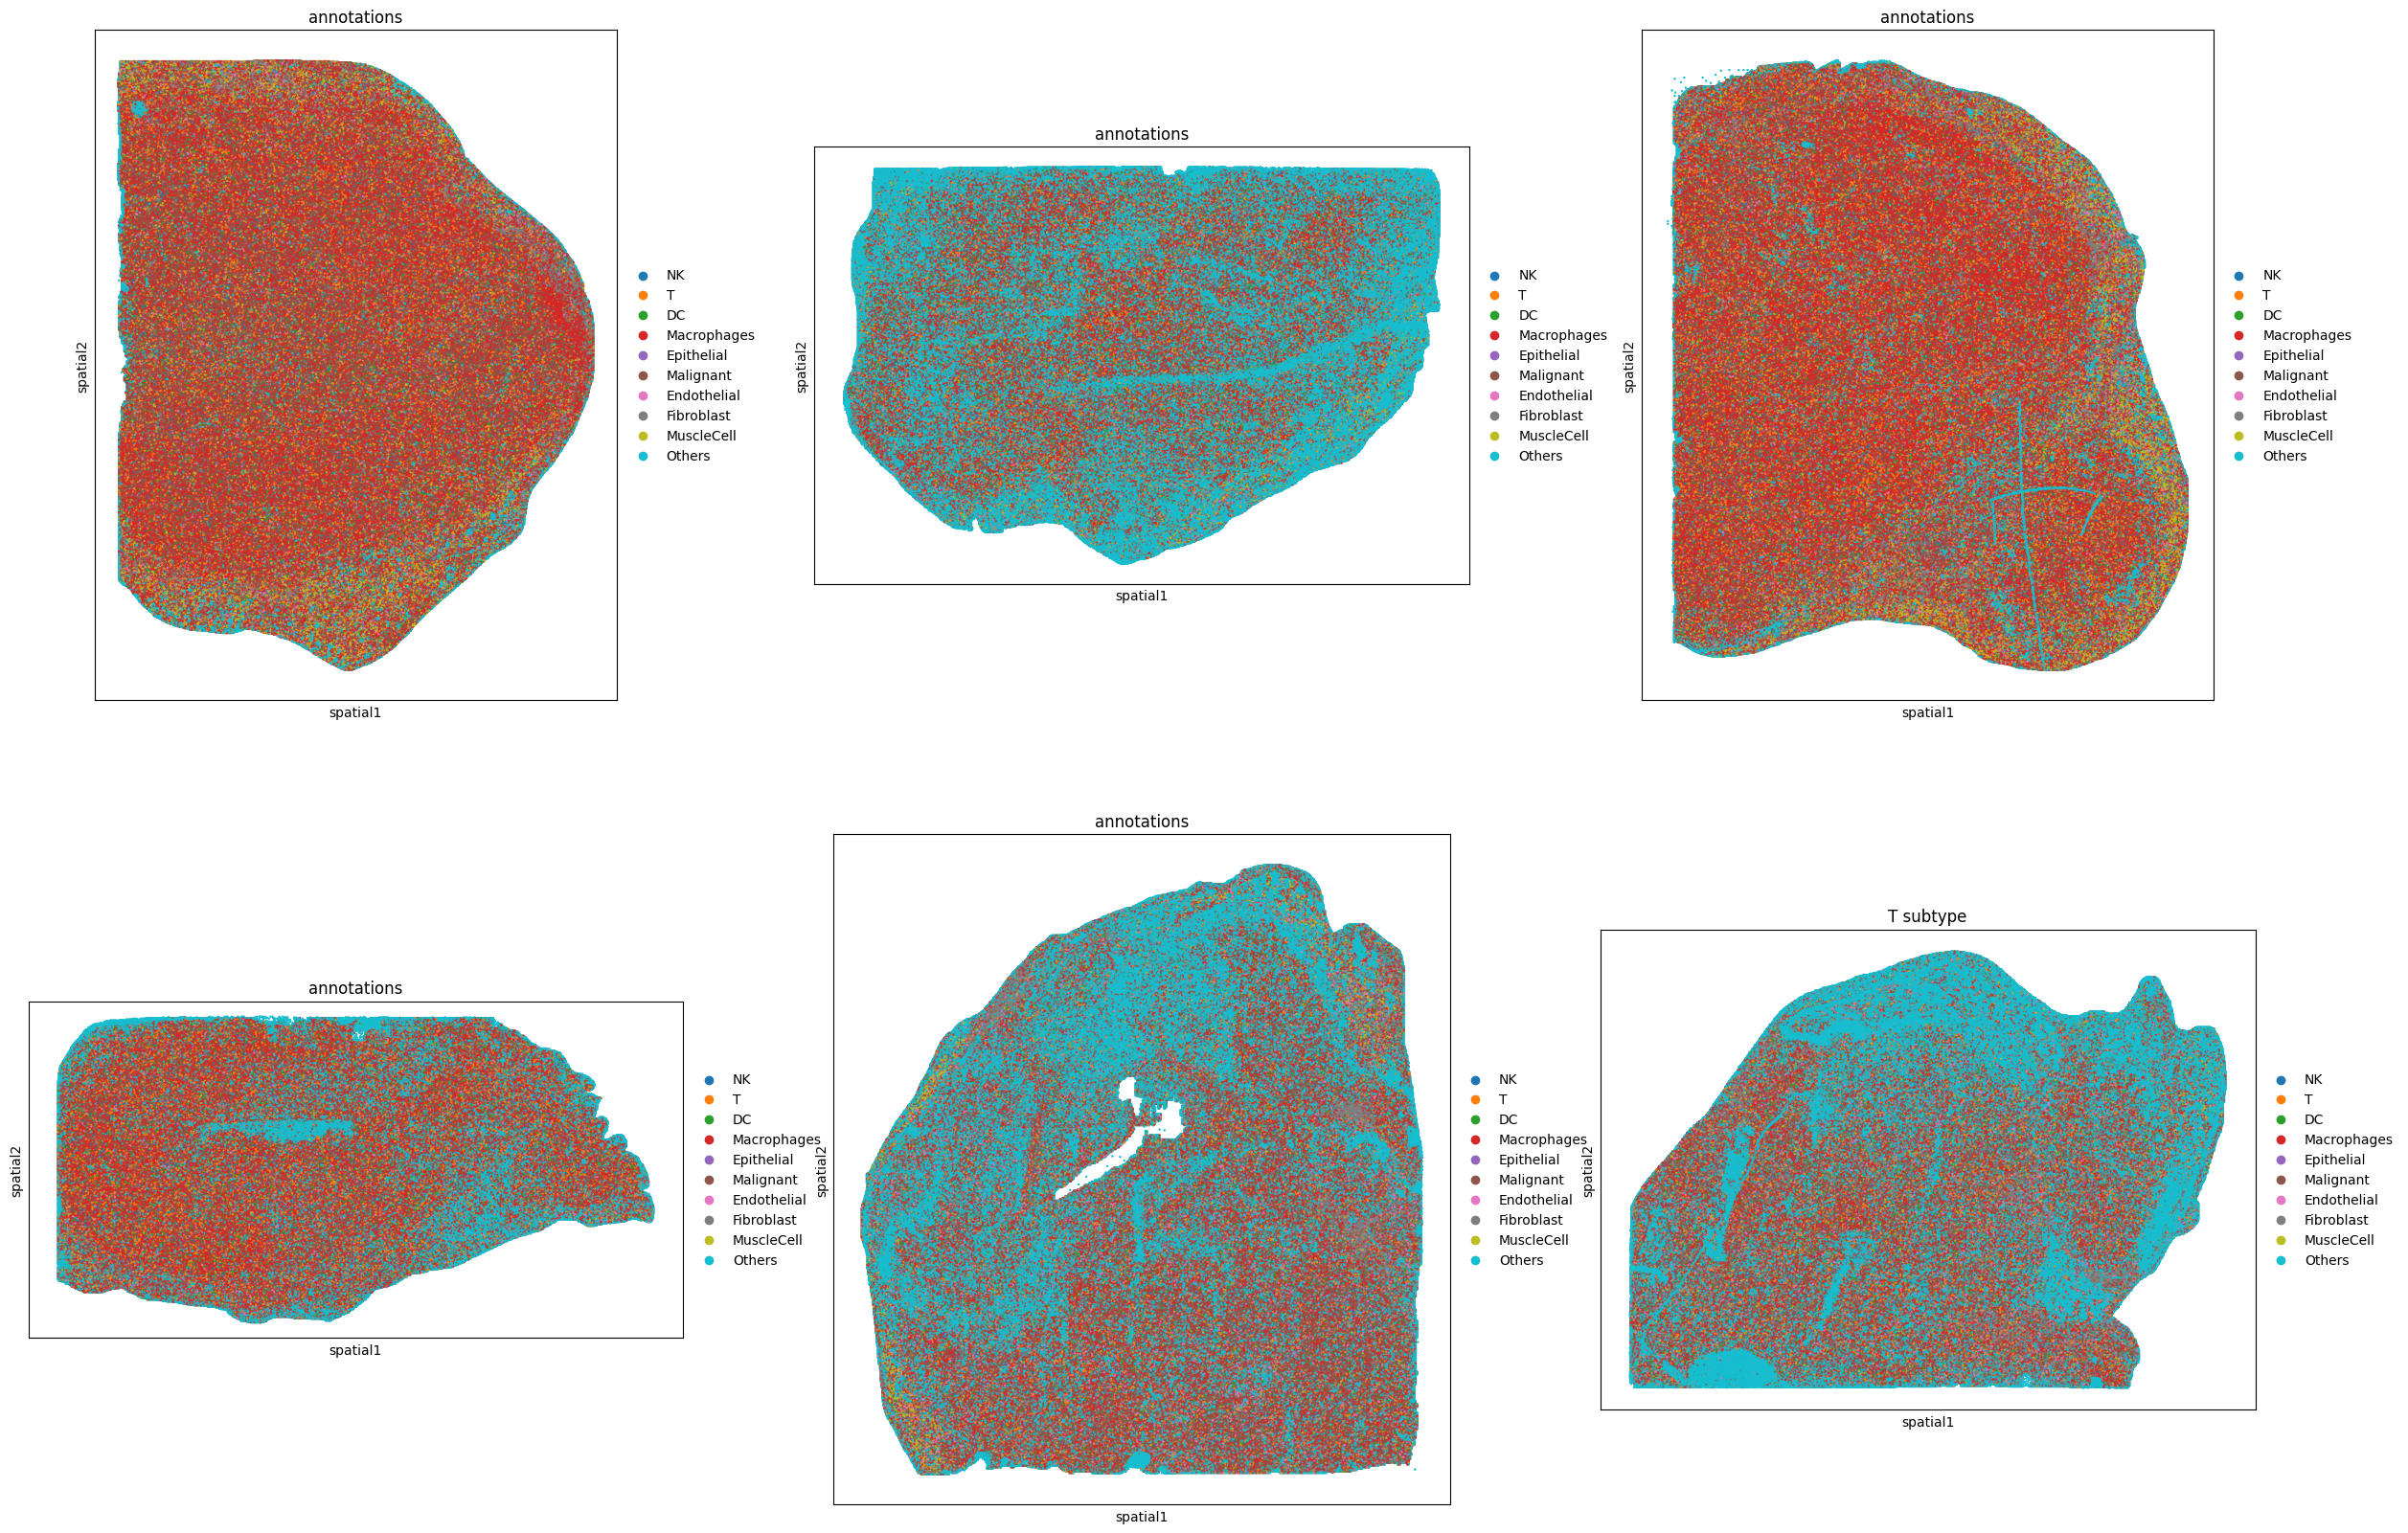

In [25]:
fig, ax = plt.subplots(2, 3, figsize=(30, 20))
for idx, marker in enumerate(np.unique(fdata.obs["marker"])):
    fdata_ = fdata[fdata.obs["marker"] == marker]
    sq.pl.spatial_scatter(fdata_, color="annotations", shape=None, size=1, ax=ax[idx // 3, idx % 3])
plt.title("T subtype")
plt.show()

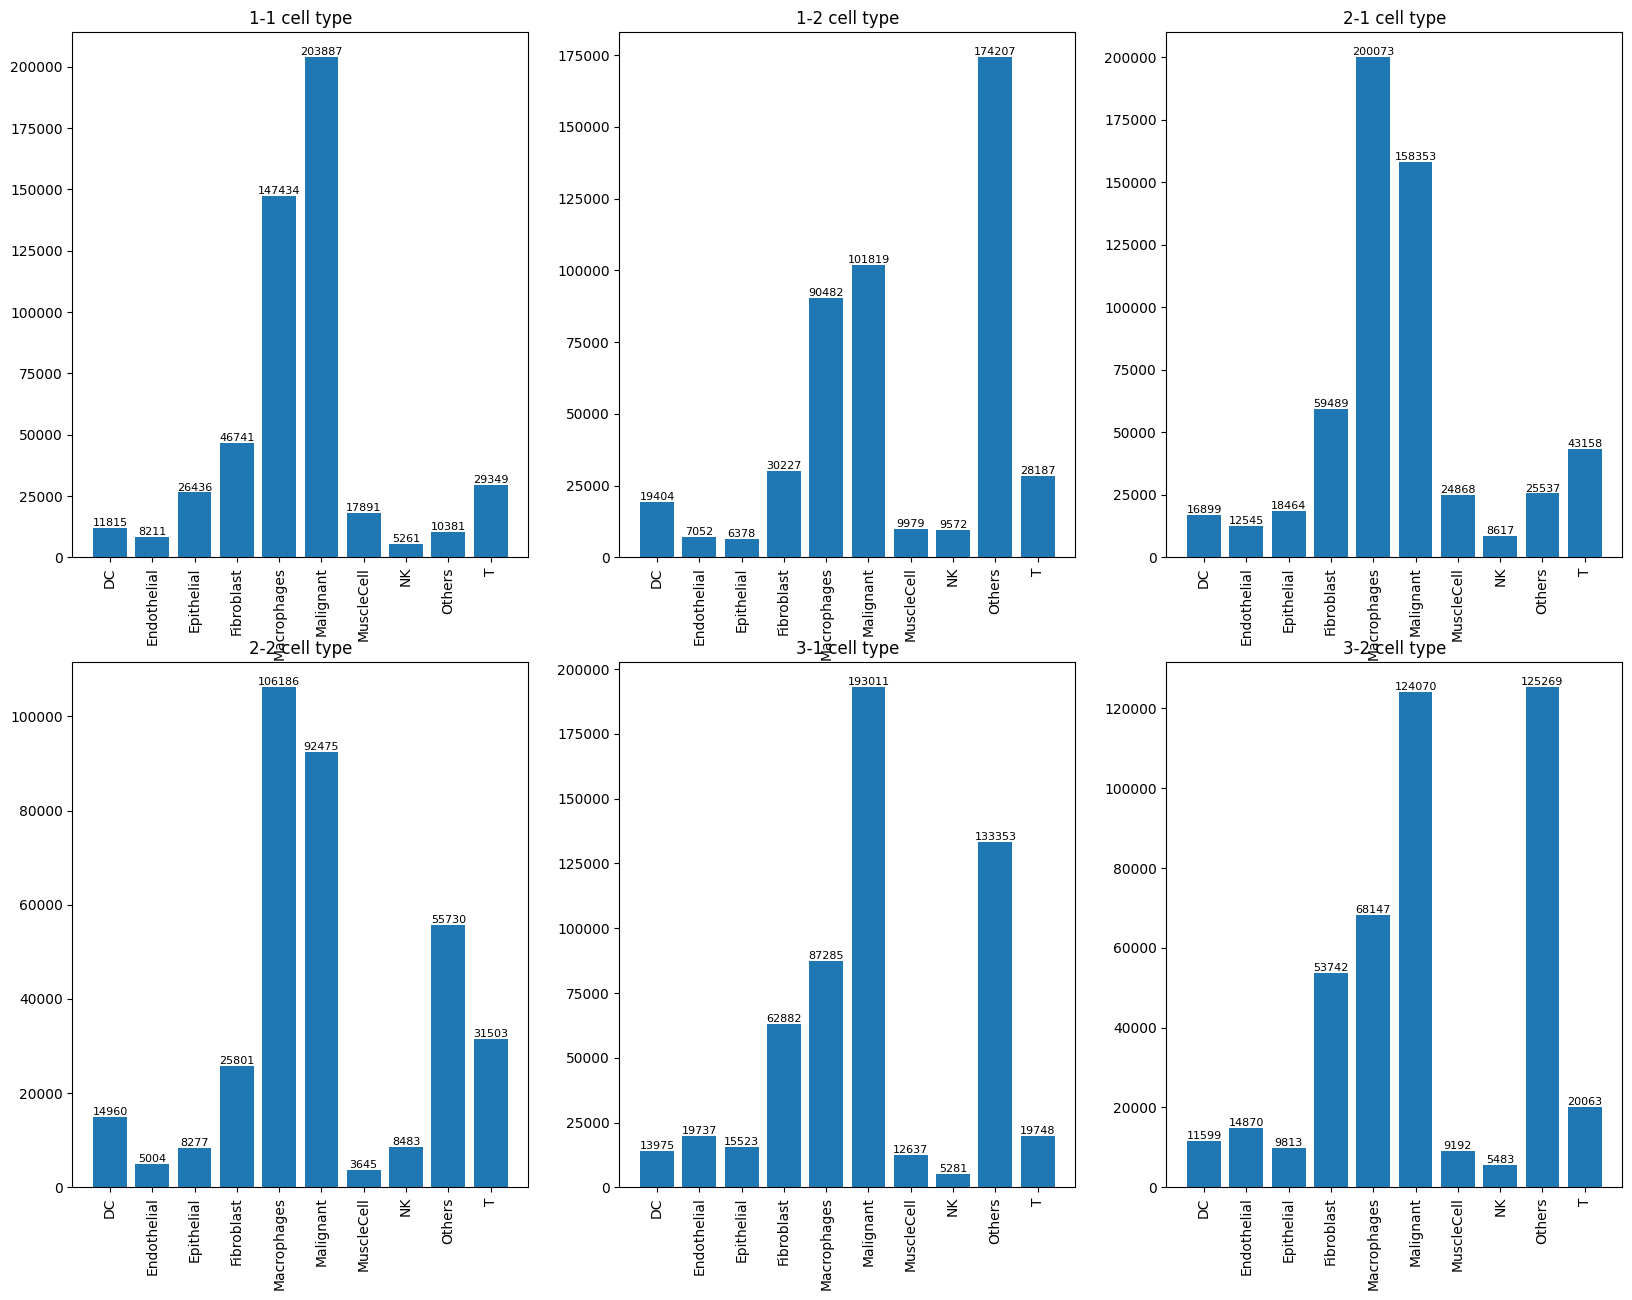

In [34]:
fig, ax = plt.subplots(2, 3, figsize=(20, 15))
for idx, marker in enumerate(np.unique(fdata.obs["marker"])):
    fdata_ = fdata[fdata.obs["marker"] == marker]
    ax_ = ax[idx // 3, idx % 3]
    visualize_results(fdata_, ax_, key="annotations")
    ax_.set_title(marker + " cell type")
plt.show()

In [35]:
np.unique(fdata.obs["annotations"])

array(['DC', 'Endothelial', 'Epithelial', 'Fibroblast', 'Macrophages',
       'Malignant', 'MuscleCell', 'NK', 'Others', 'T'], dtype=object)

In [36]:
fdata.obs["annotations"] = np.array(fdata.obs["annotations"])
fdata.obs.loc[adata_t.obs.index, "annotations"] = adata_t.obs['anno_1']

fdata.obs["annotations"] = pd.Series(fdata.obs["annotations"]).astype("category")
fdata.obs['annotations'] = fdata.obs['annotations'].cat.reorder_categories(['NK', 'effector T', 'stem-like T', 'memory T', 'exhausted T', 'Unknown T', 'DC', 'Macrophages', 'Epithelial', 'Malignant', 'Endothelial', 'Fibroblast', 'MuscleCell', 'Others'], ordered = True)

In [37]:
fdata.write_h5ad("./RNA/Multitime.annotation.fixed.h5")